In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from municipalities_abm.model import SBPAdoption

%matplotlib inline

In [543]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm")

In [544]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=6)

In [545]:
# Where to save the figures
PROJECT_ROOT_DIR = "./analysis_results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Model initialization and step

In [546]:
ml_model_name = "rnd_for_TTFTTF1"

In [547]:
ml_folder_path = "./ml_model/" + str(ml_model_name)
features_path = ml_folder_path + "/features.csv"
ml_model_path = ml_folder_path + "/model.pkl"
sbp_payments_path = "./data/sbp_payments.xlsx"

In [548]:
start_year = 1996

In [549]:
# Note that the model is initialized with a seed to have the same results
model = SBPAdoption(ml_features_path=features_path,
                    ml_model_path=ml_model_path,
                    sbp_payments_path=sbp_payments_path,
                    initial_year=start_year)

In [550]:
stop_year = 2019

for i in range(1996, stop_year):
    model.step()
    print("Step", str(i))

Step 1996
Step 1997
Step 1998
Step 1999
Step 2000
Step 2001
Step 2002
Step 2003
Step 2004
Step 2005
Step 2006
Step 2007
Step 2008
Step 2009
Step 2010
Step 2011
Step 2012
Step 2013
Step 2014
Step 2015
Step 2016
Step 2017
Step 2018


# Data collection

In [551]:
def collect_model_level_data(abm_model):
    yearly_adoption_portugal = abm_model.yearly_adoption_ha_port
    return yearly_adoption_portugal

In [552]:
def collect_agent_level_data(abm_model):
    """
    Function to collect data at the individual agent level
    
    Returns
    -------
    municipalities_adoption : pd DataFrame
        Multiindex DataFrame reporting for each muninicipality and for each year the ratio of SBP are adopted
    """
    municipality_agents = abm_model.schedule.agents
    municipalities = [munic.Municipality for munic in municipality_agents]
    
    # Create the empty df
    years = np.arange(start_year, stop_year)
    municipalities_adoption = pd.MultiIndex.from_product([municipalities, years])
    municipalities_adoption = municipalities_adoption.to_frame()
    municipalities_adoption.drop(municipalities_adoption.columns, axis=1, inplace=True)
    municipalities_adoption.index.rename(['Municipality', 'Year'], inplace=True)
    municipalities_adoption['predicted_adoption'] = None
    
    # Create a dictionary mapping to each municipality name the Series of its adoption in each year
    yearly_adoptions = [munic.yearly_adoption for munic in municipality_agents]
    map_dict = dict(zip(municipalities, yearly_adoptions))
    for adoption in map_dict.values():
        adoption.name = 'predicted_adoption' # Necessary to use .udpdate() method

    # For each municipality, updates the values of adoption    
    for munic in municipalities:
        df = municipalities_adoption.loc[munic]
        df.update(map_dict[munic])
        municipalities_adoption.loc[munic] = df.values
        
    return municipalities_adoption

In [553]:
yearly_adoption_portugal = collect_model_level_data(model)

In [554]:
munic_yearly_adoption = collect_agent_level_data(model)

# Model validation

## Real data loading

In [555]:
path_to_adoption_port_real = "./data/for_validation/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)

In [556]:
path_to_adoption_munic_real = "./data/for_validation/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

## Macro-validation

### Plot predicted vs real adoption in Portugal

Saving figure Yearly adoption Portugal rnd_for_TTFTTF1


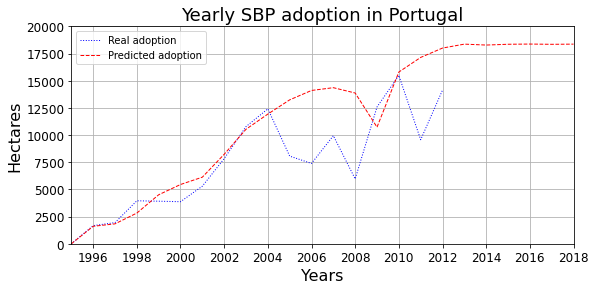

In [557]:
# Base figure
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(9, 4)
ax_pr.set_xlabel("Years", fontsize=16)
ax_pr.set_ylabel("Hectares", fontsize=16)
ax_pr.set_title("Yearly SBP adoption in Portugal", fontsize=18)
ax_pr.set_xlim(yearly_adoption_portugal.index[0], yearly_adoption_portugal.index[-1])
xticks = [year for year in yearly_adoption_portugal.index if year%2 == 0]
ax_pr.set_xticks(xticks)
ax_pr.set_ylim(0, 20000)
ax_pr.grid(True)

# Plot adoptions
ax_pr.plot(yearly_adoption_portugal_real.index, yearly_adoption_portugal_real.values, 'b:', linewidth=1, label='Real adoption')
ax_pr.plot(yearly_adoption_portugal.index, yearly_adoption_portugal.values, 'r--', linewidth=1, label='Predicted adoption')
ax_pr.legend(loc='best')

save_fig(("Yearly adoption Portugal " + ml_model_name))

### Plot predicted vs real cumulative adoption in Portugal

In [558]:
cumulative_adoption_portugal = yearly_adoption_portugal.cumsum()
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative adoption Portugal rnd_for_TTFTTF1


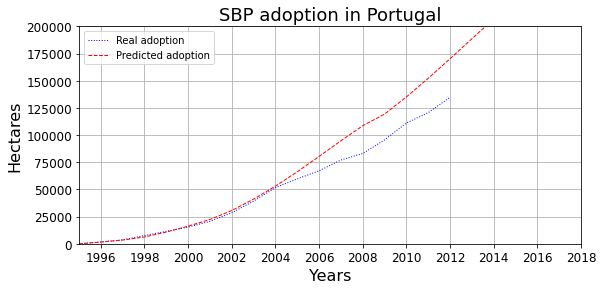

In [559]:
# Base figure
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(9, 4)
ax_pr.set_xlabel("Years", fontsize=16)
ax_pr.set_ylabel("Hectares", fontsize=16)
ax_pr.set_title("SBP adoption in Portugal", fontsize=18)
ax_pr.set_xlim(cumulative_adoption_portugal.index[0], cumulative_adoption_portugal.index[-1])
xticks = [year for year in cumulative_adoption_portugal.index if year%2 == 0]
ax_pr.set_xticks(xticks)
ax_pr.set_ylim(0, 200000)
ax_pr.grid(True)

# Plot adoptions
ax_pr.plot(cumulative_adoption_portugal_real.index, cumulative_adoption_portugal_real.values, 'b:', linewidth=1,
           label='Real adoption')
ax_pr.plot(cumulative_adoption_portugal.index, cumulative_adoption_portugal.values, 'r--', linewidth=1,
           label='Predicted adoption')
ax_pr.legend(loc='best')

save_fig(("Cumulative adoption Portugal " + ml_model_name))

## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation is this is before 2012

In [560]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real, munic_yearly_adoption], axis=1, join='inner')
final_year_val = min(2012, stop_year)
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) >= final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [561]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [562]:
from sklearn.metrics import mean_squared_error, r2_score

def micro_validation(adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    pred = adoption_rp['predicted_adoption'].values
    
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(real, pred)
    #adj_r2 = adjusted_r2(r2_scores, (num_test_points // folds), num_features)
    print("Total RMSE:", str(rmse))
    print("Total R2 score:", str(r2))
    
    get_yearly_and_cumul_rmse(adoption_rp)

Total RMSE: 0.008831997209820119
Total R2 score: 0.09338741768459113


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
RMSE on year,0.004118,0.003489,0.003283,0.003599,0.003396,0.003691,0.005944,0.006600,0.006749,0.010138,0.007479,0.012502,0.009219,0.009768,0.019187,0.013493
Relative RMSE on year,0.856904,0.804520,0.863041,0.721254,0.640223,0.720038,0.786589,0.938610,0.794507,0.934871,1.545168,1.045015,1.336576,0.870610,0.953195,1.103095
RMSE till year,0.004118,0.003817,0.003648,0.003636,0.003589,0.003606,0.004024,0.004429,0.004743,0.005525,0.005730,0.006567,0.006807,0.007060,0.008430,0.008832
Relative RMSE till year,0.856904,0.833778,0.838340,0.804117,0.764435,0.753430,0.758421,0.781375,0.773148,0.812876,0.862286,0.896483,0.932145,0.922945,0.932136,0.952162


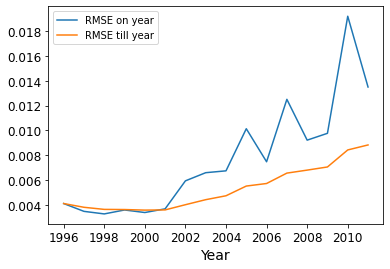

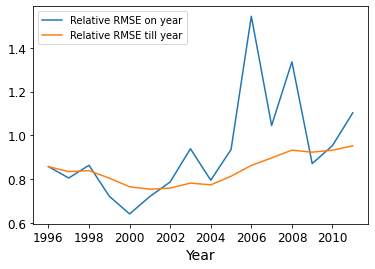

In [563]:
micro_validation(munic_adoption_real_pred)